# Assesment: Grammar Scoring Engine

=== Project Initialization ===

Importing essential libraries for audio processing, data handling, and machine learning

In [1]:
import numpy as np              # For numerical operations
import pandas as pd             # For handling datasets (CSV files, DataFrames)
import librosa                  # For audio processing and feature extraction
import torch                    # For deep learning support, if needed

print("Ready to build the Grammar Scoring Engine!")


Ready to build the Grammar Scoring Engine!


# Loading CSV's

In [2]:
import pandas as pd

# The train.csv contains filenames and their corresponding grammar scores
# The test.csv contains filenames for which we have to predict grammar scores

train_df = pd.read_csv("shl-intern-hiring-assessment/dataset/train.csv")
test_df = pd.read_csv("shl-intern-hiring-assessment/dataset/test.csv")

# Checking the number of samples in each dataset and inspecting the first few rows of training data
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (444, 2)
Test shape: (195, 1)


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


# Exploratory Data Check

In [3]:
# Check the data types of each column

print("Column Data Types:")
print(train_df.dtypes)

# Check for any missing values in the training set

print("\nMissing Values:")
print(train_df.isnull().sum())

# Check distribution of grammar scores (labels)

print("\nGrammar Score Distribution:")
print(train_df['label'].value_counts().sort_index())


Column Data Types:
filename     object
label       float64
dtype: object

Missing Values:
filename    0
label       0
dtype: int64

Grammar Score Distribution:
label
1.0      1
1.5      3
2.0     70
2.5     40
3.0     87
3.5     23
4.0     52
4.5     58
5.0    110
Name: count, dtype: int64


# Audio Visualization & Feature Exploration

Visualizing Sample Audio: audio_1261.wav


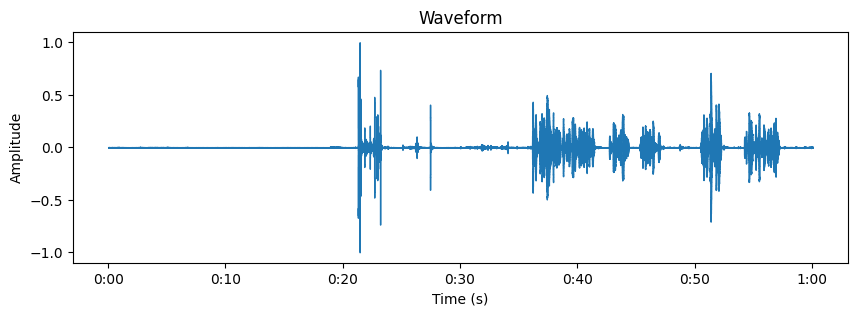

MFCC shape: (13, 1878)


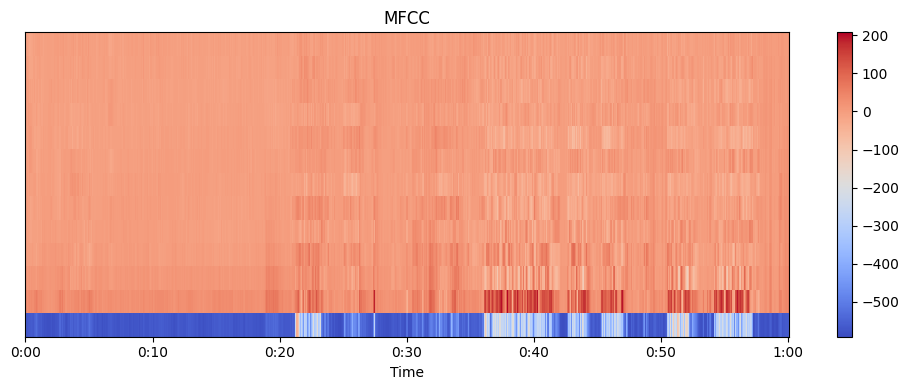

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt


# Pick a sample audio from training data
sample_filename = train_df.iloc[0]['filename']
sample_path = "shl-intern-hiring-assessment/dataset/audios_train/" + sample_filename
print(f"Visualizing Sample Audio: {sample_filename}")

# Load the audio file (no resampling to keep original quality)
y, sr = librosa.load(sample_path, sr=None)

# Plot the waveform to observe amplitude variation over time
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Extract MFCC (Mel-Frequency Cepstral Coefficients)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print("MFCC shape:", mfcc.shape)

# Visualize MFCC to inspect frequency distribution over time
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()


# Audio Feature Extraction Pipeline

We define a custom extract_features function to extract relevant audio features from each file. These features capture various speech characteristics that may correlate with grammatical fluency, such as:

MFCCs: Capture timbral and phonetic information.

Chroma STFT: Represent harmonic pitch class content.

Spectral Contrast: Describe differences in energy across frequency bands.

Zero-Crossing Rate: Indicates signal noisiness or sharpness.

Root Mean Square Energy (RMS): Measures signal loudness and dynamics.

All features are aggregated using mean and standard deviation across time, resulting in a fixed-length feature vector per audio sample.

In [5]:
import librosa
import numpy as np

def extract_features(file_path):
    """
    Extracts a set of statistical audio features from a single audio file.

    Parameters:
        file_path (str): Path to the audio file.

    Returns:
        features (list): List of aggregated audio features (mean + std) for each type.
    """

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None)
    features = []

    # === 1. MFCCs (Mel Frequency Cepstral Coefficients) ===

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))  # Mean across time
    features.extend(np.std(mfccs, axis=1))   # Variance across time

    # === 2. Chroma STFT ===
    
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))

    # === 3. Spectral Contrast ===
    
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(contrast, axis=1))
    features.extend(np.std(contrast, axis=1))

    # === 4. Zero-Crossing Rate ===
 
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    features.append(np.std(zcr))

    # === 5. Root Mean Square Energy ===
    
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    features.append(np.std(rms))

    return features



In [6]:
!pip install tqdm
from tqdm import tqdm

# Training Set Feature Extraction

In [7]:
import os

# Path to the training audio folder
audio_folder = "shl-intern-hiring-assessment/dataset/audios_train/"

# Lists to store extracted features and corresponding labels
X = []
y = []

# Iterate through each row in the training DataFrame
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting features"):
    file_path = os.path.join(audio_folder, row['filename'])  # Full path to the audio file
    features = extract_features(file_path)  # Extract audio features
    X.append(features)  # Add feature vector to dataset
    y.append(row['label'])  # Add label to target list

# Convert lists to NumPy arrays for model training
X = np.array(X)
y = np.array(y)

print("Feature extraction complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)


Extracting features: 100%|███████████████████████████████████████████████████████████| 444/444 [03:11<00:00,  2.31it/s]

Feature extraction complete!
X shape: (444, 68)
y shape: (444,)


# Splitting of the dataset

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training and Evaluation: Random Forest Regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Initialize and train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)


# Evaluate model performance using MSE and Pearson Correlation
mse = mean_squared_error(y_val, y_pred)
pearson_corr, _ = pearsonr(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")  # Lower is better
print(f"Validation Pearson Correlation: {pearson_corr:.4f}")  # Closer to 1 means better correlation


Validation MSE: 0.7975
Validation Pearson Correlation: 0.6782


# Model Training and Evaluation: XGBoost Regressor


In [10]:
from xgboost import XGBRegressor

# Initialize XGBoost Regressor with specified hyperparameters
xgb_model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict grammar scores on the validation set
xgb_pred = xgb_model.predict(X_val)

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, xgb_pred)

# Calculate Pearson Correlation to measure prediction alignment with ground truth
pearson_corr, _ = pearsonr(y_val, xgb_pred)

# Print evaluation results
print(f"[XGBoost] MSE: {mse:.4f}")
print(f"[XGBoost] Pearson Correlation: {pearson_corr:.4f}")



[XGBoost] MSE: 0.8438
[XGBoost] Pearson Correlation: 0.6278


We experimented with two different regression models to predict grammar scores:

--Random Forest Regressor--

Validation MSE: 0.7975

Pearson Correlation: 0.6782

--XGBoost Regressor--

Validation MSE: 0.8438

Pearson Correlation: 0.6278

Since the Random Forest Regressor yielded better performance both in terms of lower Mean Squared Error (MSE) and higher Pearson Correlation, we will proceed with it for generating final predictions on the test set.

# Test Set Feature Extraction

In [11]:
import os
from tqdm import tqdm

# Path to the test audio folder
test_audio_folder = "shl-intern-hiring-assessment/dataset/audios_test/"

# Lists to store features and corresponding filenames
X_test = []
filenames = []

# Loop through each test audio file and extract features
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(test_audio_folder, row['filename'])
    features = extract_features(file_path)
    X_test.append(features)
    filenames.append(row['filename'])

# Convert features to NumPy array
X_test = np.array(X_test)
print("Test feature extraction complete. Shape:", X_test.shape)





100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]

Test feature extraction complete. Shape: (195, 68)


# Generating Submission File

In [12]:
# Make predictions using the trained Random Forest model
test_preds = model.predict(X_test)  

# Create submission DataFrame using the test_df structure
submission = test_df.copy()
submission['label'] = test_preds

# Save submission file to specified directory
submission.to_csv("shl-intern-hiring-assessment/dataset/submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv


# Actual vs Predicted Grammar Scores (Validation Set)




To interpret model performance, we visualize how closely the predicted grammar scores match the actual scores on the validation set.
The red dashed diagonal line represents a perfect prediction (where predicted = actual).

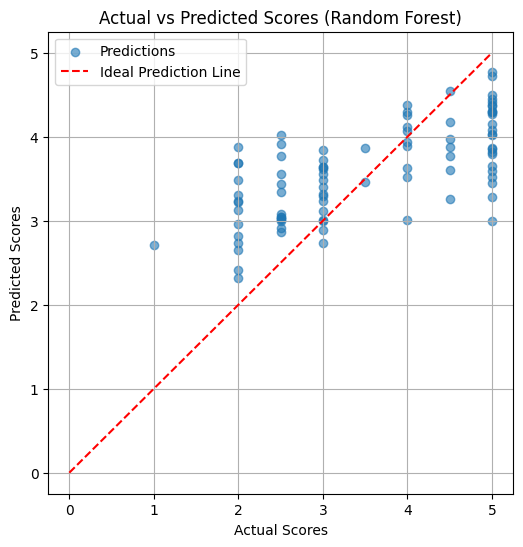

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6, label='Predictions')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Ideal Prediction Line')
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Scores (Random Forest)")
plt.grid(True)
plt.legend()
plt.show()


# Sample Predictions on Training Audio Files

To qualitatively inspect our model’s performance, we randomly select 5 audio files from the training dataset and compare their actual grammar score with the predicted score from the Random Forest model.

In [14]:
import random

# Randomly sample 5 training audio files to evaluate model predictions
print("Sample predictions from training data:\n")

for i in random.sample(range(len(train_df)), 5):
    filename = train_df.iloc[i]['filename']
    true_label = train_df.iloc[i]['label']
    file_path = os.path.join(audio_folder, filename)

    # Extract features and reshape for prediction
    features = extract_features(file_path)
    features = np.array(features).reshape(1, -1)

    # Predict grammar score using trained Random Forest model
    pred = model.predict(features)[0]

    # Print actual vs predicted score
    print(f"{filename} → Actual: {true_label}, Predicted: {pred:.2f}")


Sample predictions from training data:

audio_813.wav → Actual: 3.0, Predicted: 2.85
audio_1332.wav → Actual: 4.0, Predicted: 3.70
audio_414.wav → Actual: 5.0, Predicted: 4.83
audio_961.wav → Actual: 4.5, Predicted: 4.34
audio_744.wav → Actual: 2.5, Predicted: 2.92


# Project Report: Grammar Scoring Engine

# Objective


The goal of this project was to build a Grammar Scoring Engine that takes in spoken audio samples and predicts a continuous grammar score between 0 and 5, based on the MOS Likert Grammar Score rubric. We were provided with a labeled training dataset of 444 audio files and an unlabeled test set of 195 samples.

# Approach & Preprocessing

We started by exploring the data, checking label distributions, and inspecting the structure of the audio files. Each audio file was then preprocessed to extract meaningful features using the librosa library. The following audio features were extracted:

MFCCs: Captures the timbral structure of speech.

Chroma STFT: Highlights harmonic content and pitch classes.

Spectral Contrast: Reflects articulation and clarity.

Zero-Crossing Rate: Indicates signal sharpness.

Root Mean Square Energy (RMS): Represents loudness and clarity.

We calculated both the mean and standard deviation for each feature type to capture their temporal dynamics.

# Model Pipeline

After feature extraction, we created a modeling pipeline as follows:

Train/Test Split: The dataset was split into training and validation sets (80/20).

Model Training: We experimented with two regressors:

RandomForestRegressor

XGBoostRegressor

Both models were trained using the extracted feature matrix (X) and grammar labels (y).

Evaluation: We used Mean Squared Error (MSE) and Pearson Correlation as our primary metrics for model evaluation.

# Results & Model Selection

--Random Forest Regressor--

Validation MSE: 0.7975

Pearson Correlation: 0.6782

--XGBoost Regressor--

Validation MSE: 0.8438

Pearson Correlation: 0.6278
    
Random Forest showed slightly better performance in both metrics, so we continued with it for the final submission.

We also visualized the Actual vs. Predicted scores, and tested the model against random samples from the training set to verify that the predictions made sense contextually.

# Final Submission

We applied the trained Random Forest model on the test set after extracting features using the same process. The predicted scores were saved in submission.csv, formatted as required.

